In [2]:
from sklearn import datasets
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.datasets import mnist

from neural_network import NeuralNetworkImpl
from utils import compute_accuracy_multilabel

Using TensorFlow backend.


In [3]:
# This notebook could be run with one of two datasets. By default uses the much larger MNIST dataset
# with 60,000 train examples and 10,000 test examples.
dataset_to_use = 'mnist'

In [4]:
if dataset_to_use == 'digits':
# SKLEARN digits dataset
    digits = datasets.load_digits()
    X = digits['data'].T
    Y = digits['target']
    print(X.shape)
    print(Y.shape)
    train_size = 1500
    test_size = X.shape[1] - train_size

    X_train_images = digits.images[0:train_size]
    X_test_images = digits.images[train_size:]

    X_train = X[:, 0:train_size]
    Y_train_labels = Y[0:train_size]
    X_test = X[:, train_size:]
    Y_test_labels = Y[train_size:]

    Y_train = np.zeros((10, Y_train_labels.shape[0]))
    Y_train[Y_train_labels[:], np.arange(Y_train_labels.shape[0])] = 1

    Y_test = np.zeros((10, Y_test_labels.shape[0]))
    Y_test[Y_test_labels[:], np.arange(Y_test_labels.shape[0])] = 1
elif dataset_to_use == 'mnist':
# MNIST dataset
    (X_train_images, Y_train_labels), (X_test_images, Y_test_labels) = mnist.load_data()

    # Normalize the image data because the data range is [0, 255]. Without normalization the
    # neural net implementation performs quite miserable, usually always predicting just one 
    # label for all inputs.
    X_train_images = X_train_images / 255.
    X_test_images = X_test_images / 255.
    
    X_train = X_train_images.reshape((X_train_images.shape[0], -1)).T
    X_test = X_test_images.reshape((X_test_images.shape[0], -1)).T
    
    X_train = X_train
    X_test = X_test

    Y_train = np.zeros((10, Y_train_labels.shape[0]))
    Y_train[Y_train_labels[:], np.arange(Y_train_labels.shape[0])] = 1

    Y_test = np.zeros((10, Y_test_labels.shape[0]))
    Y_test[Y_test_labels[:], np.arange(Y_test_labels.shape[0])] = 1
else:
    raise "No dataset chosen"

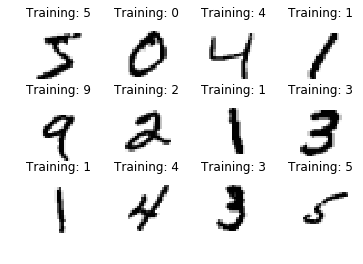

In [5]:
# Plot some training examples
images_and_labels = list(zip(X_train_images, Y_train_labels))
for index, (image, label) in enumerate(images_and_labels[:12]):
    plt.subplot(3, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)
plt.show()

Parameters to train: 7965
=== iteration 0, cost: 0.9251765438659313, accuracy: 0.046875
=== iteration 10, cost: 0.3190971781815695, accuracy: 0.953125
=== iteration 20, cost: 0.2891198776245073, accuracy: 0.890625
=== iteration 30, cost: 0.27166288867147187, accuracy: 0.9375
=== iteration 40, cost: 0.2628364965935516, accuracy: 0.953125
=== iteration 50, cost: 0.25550492898717536, accuracy: 0.890625
=== iteration 60, cost: 0.2505100238289654, accuracy: 0.96875
=== iteration 70, cost: 0.24379948325427722, accuracy: 0.953125
=== iteration 80, cost: 0.2407921928148438, accuracy: 0.921875
=== iteration 90, cost: 0.23719685908120922, accuracy: 0.9375
=== iteration 100, cost: 0.234454142966869, accuracy: 0.921875
=== iteration 110, cost: 0.22978408487239718, accuracy: 1.0
=== iteration 120, cost: 0.22730684417015065, accuracy: 0.96875
=== iteration 130, cost: 0.2259857131111008, accuracy: 0.984375
=== iteration 140, cost: 0.22496759767951874, accuracy: 0.9375
=== iteration 150, cost: 0.22345

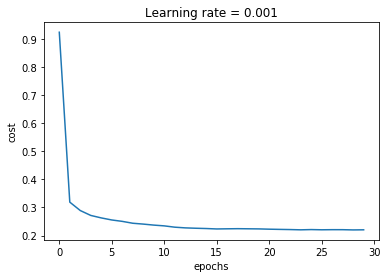

Neural net train accuracy: 0.9439833333333334
Neural net test accuracy: 0.9382000000000003


In [9]:
# Train a neural network using my implementation with two hidden layers of sizes 10 and 5 and one output 
# layer using softmax activation and 10 outputs, one per label.
model_nn = NeuralNetworkImpl(layer_sizes=[10, 5, 10], 
                             layer_activations=['relu', 'relu', 'softmax'], 
                             alpha=0.001, 
                             epochs=300, 
                             mini_batch_size=64, 
                             regularization=0.1, 
                             optimization_algorithm='adam')
model_nn.train(X_train, Y_train)
accuracy = compute_accuracy_multilabel(model_nn, X_train, Y_train)
print("Neural net train accuracy: {}".format(accuracy)) 
accuracy = compute_accuracy_multilabel(model_nn, X_test, Y_test)
print("Neural net test accuracy: {}".format(accuracy))

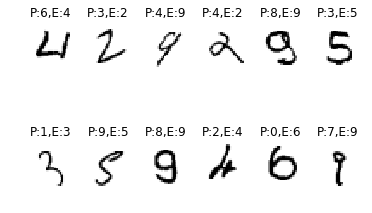

In [10]:
# Plot test examples in which the neural net was wrong.
expected = Y_test
predicted = model_nn.predict(X_test)

images_and_predictions = list(zip(X_test_images, np.argmax(predicted, axis=0), np.argmax(expected, axis=0)))
filtered_examples = [triplet for triplet in images_and_predictions if triplet[1] != triplet[2]]
for index, (image, prediction, expected) in enumerate(filtered_examples[:12]):
    plt.subplot(2, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("P:{},E:{}".format(prediction, expected))

plt.show()

For some of these examples I can see why the network was confused.

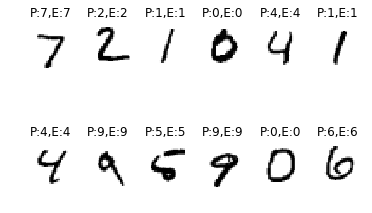

In [16]:
# Plot test examples in which the neural net was right.
filtered_examples = [triplet for triplet in images_and_predictions if triplet[1] == triplet[2]]
for index, (image, prediction, expected) in enumerate(filtered_examples[:12]):
    plt.subplot(2, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("P:{},E:{}".format(prediction, expected))

plt.show()

In [17]:
# Train a Keras neural net similar to the one used above to compare my implementation with the one in Keras.
model = Sequential()
model.add(Dense(10, input_dim=28*28))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train.T, Y_train.T, epochs=300, batch_size=64, verbose=1)

score = model.evaluate(X_train.T, Y_train.T, batch_size=64)
print("Keras NN score: {}".format(score))

score = model.evaluate(X_test.T, Y_test.T, batch_size=64)
print("Keras NN score: {}".format(score))

Epoch 1/300
60000/60000 [==============================] - 3s - loss: 1.1016 - acc: 0.6186     
Epoch 2/300
60000/60000 [==============================] - 2s - loss: 0.4575 - acc: 0.8609     
Epoch 3/300
60000/60000 [==============================] - 2s - loss: 0.3885 - acc: 0.8830     
Epoch 4/300
60000/60000 [==============================] - 2s - loss: 0.3477 - acc: 0.8960     
Epoch 5/300
60000/60000 [==============================] - 2s - loss: 0.3151 - acc: 0.9072     
Epoch 6/300
60000/60000 [==============================] - 2s - loss: 0.2902 - acc: 0.9151     
Epoch 7/300
60000/60000 [==============================] - 2s - loss: 0.2727 - acc: 0.9200     
Epoch 8/300
60000/60000 [==============================] - 2s - loss: 0.2601 - acc: 0.9233     
Epoch 9/300
60000/60000 [==============================] - 2s - loss: 0.2507 - acc: 0.9264     
Epoch 10/300
60000/60000 [==============================] - 2s - loss: 0.2442 - acc: 0.9280     
Epoch 11/300
60000/60000 [=============

60000/60000 [==============================] - 3s - loss: 0.1515 - acc: 0.9546     
Epoch 169/300
60000/60000 [==============================] - 3s - loss: 0.1506 - acc: 0.9544     
Epoch 170/300
60000/60000 [==============================] - 3s - loss: 0.1511 - acc: 0.9542     
Epoch 171/300
60000/60000 [==============================] - 3s - loss: 0.1500 - acc: 0.9542     
Epoch 172/300
60000/60000 [==============================] - 3s - loss: 0.1511 - acc: 0.9547     
Epoch 173/300
60000/60000 [==============================] - 3s - loss: 0.1504 - acc: 0.9546     
Epoch 174/300
60000/60000 [==============================] - 3s - loss: 0.1506 - acc: 0.9545     
Epoch 175/300
60000/60000 [==============================] - 3s - loss: 0.1498 - acc: 0.9548     
Epoch 176/300
60000/60000 [==============================] - 3s - loss: 0.1503 - acc: 0.9540     
Epoch 177/300
60000/60000 [==============================] - 3s - loss: 0.1490 - acc: 0.9551     
Epoch 178/300
60000/60000 [=======

Parameters to train: 16020
=== iteration 0, cost: 0.5741170507432175, accuracy: 0.109375
=== iteration 10, cost: 0.15695996039280644, accuracy: 0.9375
=== iteration 20, cost: 0.14116564057762868, accuracy: 0.9375
=== iteration 30, cost: 0.13315417517874437, accuracy: 0.96875
=== iteration 40, cost: 0.13027642411289872, accuracy: 0.984375
=== iteration 50, cost: 0.12620654486168464, accuracy: 0.953125
=== iteration 60, cost: 0.12495964327224014, accuracy: 0.96875
=== iteration 70, cost: 0.12312400008737531, accuracy: 0.984375
=== iteration 80, cost: 0.12237549790205549, accuracy: 0.96875
=== iteration 90, cost: 0.12070588416231971, accuracy: 0.984375
=== iteration 100, cost: 0.12034098060484388, accuracy: 0.96875
=== iteration 110, cost: 0.11996269218174084, accuracy: 0.96875
=== iteration 120, cost: 0.11890419237016019, accuracy: 0.984375
=== iteration 130, cost: 0.11835306464365018, accuracy: 0.96875
=== iteration 140, cost: 0.11816091763351992, accuracy: 0.96875
=== iteration 150, co

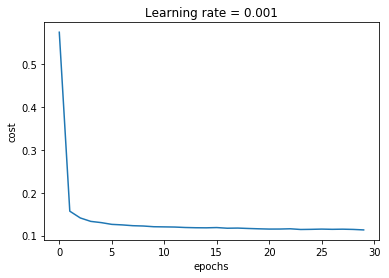

Neural net train accuracy: 0.9743500000000003
Neural net test accuracy: 0.9674000000000003


In [18]:
# Train another neural net using my implementation, this time using bigger hidden layers, 
# just to see if that helps. The number of params to train is roughly twice bigger now.
model_nn_2 = NeuralNetworkImpl(layer_sizes=[20, 10, 10], 
                             layer_activations=['relu', 'relu', 'softmax'], 
                             alpha=0.001, 
                             epochs=300, 
                             mini_batch_size=64, 
                             regularization=0.1, 
                             optimization_algorithm='adam')
model_nn_2.train(X_train, Y_train)
accuracy = compute_accuracy_multilabel(model_nn_2, X_train, Y_train)
print("Neural net train accuracy: {}".format(accuracy)) 
accuracy = compute_accuracy_multilabel(model_nn_2, X_test, Y_test)
print("Neural net test accuracy: {}".format(accuracy))

The improvement is significant this time. For the test set it went up from 93.8% to 96.7%. Let's look at some of the examples that we predicted incorrectly.

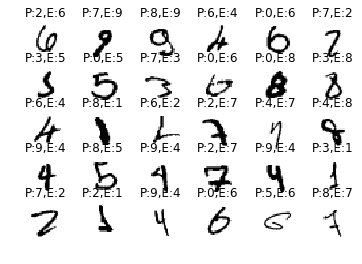

In [22]:
# Plot test examples in which the neural net was wrong.
expected = Y_test
predicted = model_nn_2.predict(X_test)

images_and_predictions = list(zip(X_test_images, np.argmax(predicted, axis=0), np.argmax(expected, axis=0)))
filtered_examples = [triplet for triplet in images_and_predictions if triplet[1] != triplet[2]]
for index, (image, prediction, expected) in enumerate(filtered_examples[:30]):
    plt.subplot(5, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("P:{},E:{}".format(prediction, expected))

plt.show()

Parameters to train: 89610
=== iteration 0, cost: 0.30967795454323155, accuracy: 0.046875
=== iteration 10, cost: 0.09813022113377089, accuracy: 0.984375
=== iteration 20, cost: 0.09183210574694962, accuracy: 0.984375
=== iteration 30, cost: 0.08990102895389121, accuracy: 0.984375
=== iteration 40, cost: 0.0874932850492776, accuracy: 0.984375
=== iteration 50, cost: 0.08650385144037556, accuracy: 0.96875
=== iteration 60, cost: 0.08619490720083618, accuracy: 0.984375
=== iteration 70, cost: 0.08483555951297632, accuracy: 1.0
=== iteration 80, cost: 0.08557488610787091, accuracy: 0.984375
=== iteration 90, cost: 0.0847638447535431, accuracy: 1.0
=== iteration 100, cost: 0.0845875030885394, accuracy: 0.984375
=== iteration 110, cost: 0.08325454416838039, accuracy: 0.984375
=== iteration 120, cost: 0.08328593587637927, accuracy: 0.984375
=== iteration 130, cost: 0.08348498837038291, accuracy: 0.984375
=== iteration 140, cost: 0.08320721569004301, accuracy: 0.984375
=== iteration 150, cost

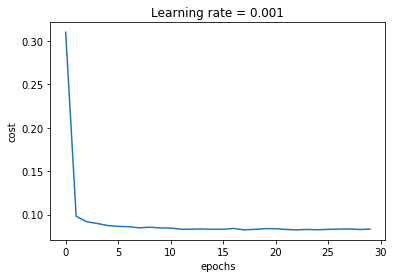

Neural net train accuracy: 0.986216666666667
Neural net test accuracy: 0.9786000000000002


In [25]:
# An even bigger neural net, which has more params to train than the training inputs. 
# Just curious to see if that helps.
model_nn_3 = NeuralNetworkImpl(layer_sizes=[100, 100, 10], 
                             layer_activations=['relu', 'relu', 'softmax'], 
                             alpha=0.001, 
                             epochs=300, 
                             mini_batch_size=64, 
                             regularization=0.1, 
                             optimization_algorithm='adam')
model_nn_3.train(X_train, Y_train)
accuracy = compute_accuracy_multilabel(model_nn_3, X_train, Y_train)
print("Neural net train accuracy: {}".format(accuracy)) 
accuracy = compute_accuracy_multilabel(model_nn_3, X_test, Y_test)
print("Neural net test accuracy: {}".format(accuracy))

Test accuracy went up from 96.7% to 97.8%

Now let's try a simple conv net using Keras.

In [40]:
X_input = Input((28, 28, 1))

# zero padding
X = ZeroPadding2D((3, 3))(X_input)

# first conv layer, patch is 7x7, stride of 1, 32 filters
X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
# apply batch norm after the layer
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)

# max pooling
X = MaxPooling2D((2, 2), name='max_pool0')(X)

# second conv layer, smaller patch than the first one and with more filters: 64
X = Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
X = BatchNormalization(axis = 3, name = 'bn1')(X)
X = Activation('relu')(X)

# max pooling
X = MaxPooling2D((2, 2), name='max_pool1')(X)

# convert the outputs to vectors and feed them to a fully connected layer, 
# which produces 10 outputs using softmax activation
X = Flatten()(X)
X = Dense(10, activation='softmax', name='fc')(X)

model = Model(inputs = X_input, outputs = X, name='mnist_conv_net')

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

X_train_conv = X_train_images.reshape((60000, 28, 28 ,1))
X_test_conv = X_test_images.reshape((10000, 28, 28 ,1))

model.fit(X_train_conv, Y_train.T, epochs=10, batch_size=64, verbose=1)

score = model.evaluate(X_train_conv, Y_train.T, batch_size=64)
print("Keras NN score: {}".format(score))

score = model.evaluate(X_test_conv, Y_test.T, batch_size=64)
print("Keras NN score: {}".format(score))

Epoch 1/10
60000/60000 [==============================] - 201s - loss: 0.1208 - acc: 0.9637   - ETA: 2s - loss: 0.1214 - acc: 0.96 - ETA: 2s - loss: 0.1213 -
Epoch 2/10
60000/60000 [==============================] - 190s - loss: 0.0481 - acc: 0.9846   
Epoch 3/10
60000/60000 [==============================] - 200s - loss: 0.0355 - acc: 0.9890   
Epoch 4/10
60000/60000 [==============================] - 199s - loss: 0.0284 - acc: 0.9906   
Epoch 5/10
60000/60000 [==============================] - 199s - loss: 0.0236 - acc: 0.9925   
Epoch 6/10
60000/60000 [==============================] - 197s - loss: 0.0193 - acc: 0.9939   
Epoch 7/10
60000/60000 [==============================] - 197s - loss: 0.0182 - acc: 0.9942   
Epoch 8/10
60000/60000 [==============================] - 198s - loss: 0.0143 - acc: 0.9954   
Epoch 9/10
60000/60000 [==============================] - 199s - loss: 0.0114 - acc: 0.9964   
Epoch 10/10
 9984/10000 [============================>.] - ETA: 0sKeras NN score: 

Test accuracy went up to 99.1%, which is 1.3% more than the big neural net model used above. Let's look at some examples where it predicted incorrectly.

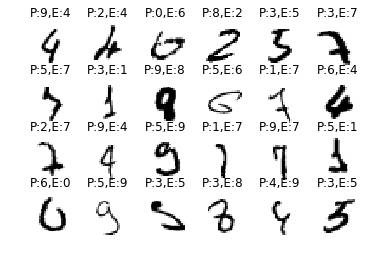

In [41]:
# Plot test examples in which the conv net was wrong.
expected = Y_test
predicted = model.predict(X_test_conv).T

images_and_predictions = list(zip(X_test_images, np.argmax(predicted, axis=0), np.argmax(expected, axis=0)))
filtered_examples = [triplet for triplet in images_and_predictions if triplet[1] != triplet[2]]
for index, (image, prediction, expected) in enumerate(filtered_examples[:24]):
    plt.subplot(4, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("P:{},E:{}".format(prediction, expected))

plt.show()

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 34, 34, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        1600      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 28, 28, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 10, 64)        51264     
__________

In [10]:
# A network similar to LeNet-5, but doing some things differently.
X_input = Input((28, 28, 1))

# first conv layer, patch is 5x5, stride of 1, 6 filters
X = Conv2D(6, (5, 5), strides = (1, 1), name = 'conv1')(X_input)
X = BatchNormalization(axis = 3, name = 'bn1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool1')(X)

# second conv layer, patch is 5x5, stride of 1, 16 filters
X = Conv2D(16, (5, 5), strides = (1, 1), name = 'conv2')(X)
X = BatchNormalization(axis = 3, name = 'bn2')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool2')(X)

# convert the outputs to vectors and feed them to a fully connected layer, 
# which produces 10 outputs using softmax activation
X = Flatten()(X)
X = Dense(120, name='fc3')(X)
X = Dense(84, name='fc4')(X)
X = Dense(10, activation='softmax', name='fc5')(X)

lenet5_model = Model(inputs = X_input, outputs = X, name='mnist_conv_net')

lenet5_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

X_train_conv = X_train_images.reshape((60000, 28, 28 ,1))
X_test_conv = X_test_images.reshape((10000, 28, 28 ,1))

lenet5_model.fit(X_train_conv, Y_train.T, epochs=50, batch_size=64, verbose=1)

score = lenet5_model.evaluate(X_train_conv, Y_train.T, batch_size=64)
print("Keras LeNet-5 NN score: {}".format(score))

score = lenet5_model.evaluate(X_test_conv, Y_test.T, batch_size=64)
print("Keras LeNet-5 NN score: {}".format(score))

Epoch 1/50
60000/60000 [==============================] - 45s - loss: 0.1847 - acc: 0.9429    
Epoch 2/50
60000/60000 [==============================] - 42s - loss: 0.0742 - acc: 0.9768    
Epoch 3/50
60000/60000 [==============================] - 41s - loss: 0.0591 - acc: 0.9819    
Epoch 4/50
60000/60000 [==============================] - 41s - loss: 0.0491 - acc: 0.9841    
Epoch 5/50
60000/60000 [==============================] - 41s - loss: 0.0436 - acc: 0.9862    
Epoch 6/50
60000/60000 [==============================] - 41s - loss: 0.0399 - acc: 0.9874    
Epoch 7/50
60000/60000 [==============================] - 41s - loss: 0.0355 - acc: 0.9887    
Epoch 8/50
60000/60000 [==============================] - 45s - loss: 0.0345 - acc: 0.9892    
Epoch 9/50
60000/60000 [==============================] - 42s - loss: 0.0303 - acc: 0.9903    
Epoch 10/50
60000/60000 [==============================] - 39s - loss: 0.0288 - acc: 0.9904    
Epoch 11/50
60000/60000 [========================